# Fama-French Factors (Python) 

<p class="lead">This Python code replicates Fama and French's (1993) methodology to construct size and value factors.</p>

## Background 

This notebook is designed to demonstrate how Fama and French's (1993) methodology can be implemented. The factors are available for download from Ken French's website (http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). The goal of this notebook is to reproduce these factors and to give researchers a set of programs that can be modified to further research in this area.

A motivated example is the paper "Should benchmark indices have alpha? Revisiting performance evalution" (Cremers, Petajisto and Zitzewitz, 2010). They present alternative factor models with modified Fama-French factors and propose improvements to this methodology. They tested their findings in benchmarking appplications (e.g. mutual funds performance tests).

<p>This set of Python code is written based on the original SAS code from WRDS that replicates the Fama French risk factors SMB and HML. Please refer to the original <a href="http://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/">Fama-French Factors</a> page for detailed discussion on methodology. The flow of the code and the dataset naming convention mimics the SAS code for easy cross-reference.</p>

## Fama-French Methodology

Fama and French (1993) identify three factors that explain a large fraction of the variation in cross-sectional firm returns. The first factor captures a market effect, the second factor captures a size effect, and the third factor captures a value effect in stock returns. As a group, these factors have come to be known as the "Fama-French Factors" and as the ‘Three-Factor Model". They have been accepted in academia and in industry as stock-market benchmarks and they are used widely for evaluating investment performance (see, for example, Barber and Odean (2000), Carhart (1997), or Womack (1996).

The Fama-French factors are based on a sample that includes all common stocks ( ordinary equity ) in the CRSP stock files (CRSP's sharecode 10 or 11), with a few additional requirements such as matching entries for the firm in the Compustat database for at least two years. Futhermore, to be included in the sample for any period July t through June t +1 the firm must have a CRSP stock price for December of year t -1 and June of year t , plus its book value of common equity for year t -1 based on Compustat data. Below we detail the procedure to recreate monthly SMB and HML factors.

## Procedure
### 1. Compustat
We used Compustat XpressFeed (annual data) as the source of historical accounting data in order to calculate the value of Book Equity. Different from quarterly data, annual data is unrestated (ideal for backtesting). Book Equity is defined as the Compustat book value of stockholders' equity plus balance sheet deferred taxes and investment tax credit (if available) minus book value of preferred stock. We did not modify the original formula that adds deferred taxes and investment tax credit. According to Kenneth French's website (as of May 2018) , it had been changes to the treatment of deferred taxes described in FASB 109.

To estimate book value of preferred stock they use the redemption or liquidation or par value of preferred stock (in that order). Since Book Equity is almost missing for the whole sample during the 1950's, we constrained our sample to begin in 1960. Additionally, we created a variable that counts number of annual records in Compustat files.

### 2. CRSP
For the purpose of this procedure we used CRSP monthly data (users can extend this calculation to daily data). The first step in working with CRSP was to merge CRSP "event" and "time-series" files. CRSP event files contain historical information on the exchange code (crucial to identify firms listed in NYSE), share codes (to identify common stocks) and delisting returns. CRSP time-series files (as CRSP.MSF) contain information such as prices, returns and shares outstanding. We merged both files using a macro program (named ‘crspmerge').

Second, we added delisting returns (to reduce any bias in portfolio returns) and calculated Market Capitalization (ME) for each CRSP security (abs(prc)*shrout). There were cases when the same firm (permco) had two or more securities (permno) on the same date. For the purpose of ME for the firm, we aggregated all ME for a given permco, date. This aggregated ME was assigned to the CRSP permno that has the largest ME. Finally, ME at June and December were flagged since (1) December ME will be used to create Book-to-Market ratio (BEME) and (2) June ME has to be positive in order to be part of the portfolio.

### 3. Merge CRSP and Compustat Data
We merged CRSP and Compustat using the CRSP CCM product (as of April 2010). We matched Compustat's gvkey (from calendar year t-1) to CRSP's permno as of June year t. Data was cleaned for unnecessary duplicates. First there were cases when different gvkeys exist for same permno-date. We solved these duplicates by only keeping those cases that are flagged as 'primary' matches by CRSP's CCM (linkprim='P' ). There were other unnecessary duplicates that were removed. Some companies may have two annual accounting records in the same calendar year. This is produced by change in the fiscal year end during the same calendar year. In these cases, we selected the last annual record for a given calendar year.

After data cleaning, the book-to-market ratio for every firm in the sample were calculated by dividing Book Equity (for fiscal year that ends on year t-1) over the market value of its common equity at the end of December year t -1. These book-to-market ratios and Market Capitalization (as of December year t-1) were assigned to June year t in order to create portfolios.

### 4. Create Portfolios by Size and Book-to-Market. Calculation of FF factors
Every June (year t) we calculated the median equity value of NYSE-listed firms using Market Capitalization at June t. We used this median to classify firms as Small or Big on portfolios created at the end of June year t. In a similar fashion, as of June year t, firms are broken into three book-to-market equity groups (Low, Medium, and High) based on the 30% and 70% break-points of the NYSE-firms with positive book-to-market equity. In both cases (for size and book-to-market classification), we restricted our sample to those firms with positive book-to-market, positive market cap at June, common equity (share code 10 and 11) and at least two years in Compustat annual file.

We created a total of six size and book-to-market equity portfolios. Portfolios are created at the end of June and kept for 12 months. Within each portfolio a monthly value-weighted return is calculated (each month, the weight is the Market Capitalization as of June year t adjusted by any change in price between the end June t and the end of the previous month). The size factor, Small minus Big (SMB) , is the difference of average return on the three Small-firm portfolios and the average return on the three Big-firm portfolios.

The value factor, High minus Low (HML) , is the difference between the average return on the two High book-to-market equity portfolios and the average return on the two Low book-to-market equity portfolios. For comparison purpose, we also calculate the number of firms in each portfolio.

## Fama French Factors Python Sample Code 

In [1]:
##########################################
# Fama French Factors
# Sep 2019
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

#######################  Part 1: Compustat ############################
# Compustat XpressFeed Variables:                                     #
# at      = Total Assets                                              #
# pstkl   = Preferred Stock Liquidating Value                         #
# txditc  = Deferred Taxes and Investment Tax Credit                  #
# pstkrv  = Preferred Stock Redemption Value                          #
# seq     = Total Parent Stockholders' Equity                         #
# pstk    = Preferred/Preference Stock (Capital) - Total              #
#                                                                     #
# In calculating Book Equity, incorporate Preferred Stock (PS) values #
# use the redemption value of PS, or the liquidation value or the par #
# value (in that order) (FF,JFE, 1993, p. 8).                         #
# Use Balance Sheet Deferred Taxes TXDITC if available.               #
# Flag for number of years in Compustat (<2 likely backfilled data).  #
#######################################################################
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc, pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1959'
                    """) # Two years of accounting data before 1962

comp['datadate']=pd.to_datetime(comp['datadate']) #convert datadate to date fmt
comp['year']=comp['datadate'].dt.year

# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])

comp['txditc']=comp['txditc'].fillna(0)

# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]

######################### Part 2: CRSP #################################
# Create a CRSP Subsample with Monthly Stock and Event Variables       #
# This procedure creates a SAS dataset named "CRSP_M"                  #
# Restrictions will be applied later                                   #
# Select variables from the CRSP monthly stock and event datasets      #
########################################################################

# sql similar to crspmerge macro                                       

crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1959' and '12/31/2017'
                      and b.exchcd between 1 and 3
                      """)

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['date']=pd.to_datetime(crsp_m['date'])
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """)
dlret.permno=dlret.permno.astype(int)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1
crsp['me']=crsp['prc'].abs()*crsp['shrout'] # calculate market equity
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()
# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])
# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)
# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])
# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()

# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()
# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

#######################################
#  Part 3: Merging CRSP and Compustat #
#######################################
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)

ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & (ccm_jun['count']>1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]
# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})
# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])
# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

######################## Part 4: Size and Book to Market Portfolios ###
# Forming Portolio by ME and BEME as of each June t                   #
# Calculate NYSE Breakpoints for Market Equity (me) and               #
# Book-to-Market (beme)                                               #
#######################################################################

# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')
# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')
# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

############### Part 5: Calculating Fama-French Factors  ##############
# Calculate monthly time series of weighted average portfolio returns #
#######################################################################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# value-weigthed return
vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']

# firm count
vwret_n=ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()


######################## Part 6: Saving Output ########################
# create SMB and HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})


Loading library list...
Done


/Users/shinggg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Outcome Discussion

We compare the output from the Python code with the one from the Fama-French Factors database, and the results are very close.

In [2]:
###################
# Compare With FF #
###################
_ff = conn.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','smb','hml']]
_ff['date']=_ff['date']+MonthEnd(0)

_ffcomp = pd.merge(_ff, ff_factors[['date','WSMB','WHML']], how='inner', on=['date'])
_ffcomp70=_ffcomp[_ffcomp['date']>='01/01/1970']
print(stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']))
print(stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML']))

(0.9960170866221992, 0.0)
(0.9803056159789335, 0.0)


We also checked the accuracy of our SMB and HML by comparing them with the values for these factors as reported by Ken French. We selected a sample from 1970 as this period is not too distorted by the fact that Compustat did not fully report Book Equity. The comparison is shown below in two scatter plots for these monthly returns. In the case of SMB, the correlation coefficient is 99.6% and for the case of HML, the correlation coefficient is 98.1%.

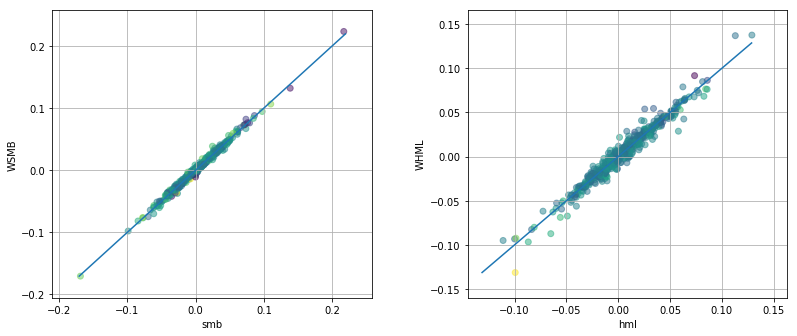

In [156]:
plt.figure()

plt.subplot(121)
plt.scatter(_ffcomp70.smb, _ffcomp70.WSMB, c=_ffcomp70.hml, alpha=0.5)
x = np.arange(min(min(_ffcomp70.smb), min(_ffcomp70.WSMB)), max(max(_ffcomp70.smb), max(_ffcomp70.WSMB)), 0.01)
plt.plot(x,x)
plt.xlabel('smb')
plt.ylabel('WSMB')
plt.grid(True)

plt.subplot(122)
plt.scatter(_ffcomp70.hml, _ffcomp70.WHML, c=_ffcomp70.smb, alpha=0.5)
x = np.arange(min(min(_ffcomp70.hml), min(_ffcomp70.WHML)), max(max(_ffcomp70.hml), max(_ffcomp70.WHML)), 0.01)
plt.plot(x,x)
plt.xlabel('hml')
plt.ylabel('WHML')
plt.grid(True)

plt.subplots_adjust(top=1, bottom=0, left=0, right=1.7, hspace=0,
                    wspace=0.3)

plt.show()

The table below lists the correlation between the Python series of SMB and HML with the Fama French factors respectively, for the sample period of 1970 onwards.

<table class="table table-striped table-hover table-bordered table-mobile tablesorter tablesorter-default">
    
        <thead>
        <tr>
            
                <th>
                    
                </th>
            
                <th>
                    
                        
                            Correlation
                        
                    
                </th>
            
        </tr>
        </thead>
    
    <tbody>
    
        <tr>
            
                
                    <th>
                        
                            
                                SMB
                            
                        
                    </th>
                 
            
                
                    <td>
                        
                            
                                99.6%
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <th>
                        
                            
                                HML
                            
                        
                    </th>
                 
            
                
                    <td>
                        
                            
                                98.1%
                            
                        
                    </td>
                 
            
        </tr>
    
    </tbody>
</table>

Including the earlier sample slightly decreases the correlation as Fama French adopted sources other than CRSP and Compustat for the earlier sample when calculating the original series.

Lastly, we present the figure below which compares the entire series of factors. Solid blue line represents the risk factor generated from the Python code, and dash red line represents the original data series from Fama French library.

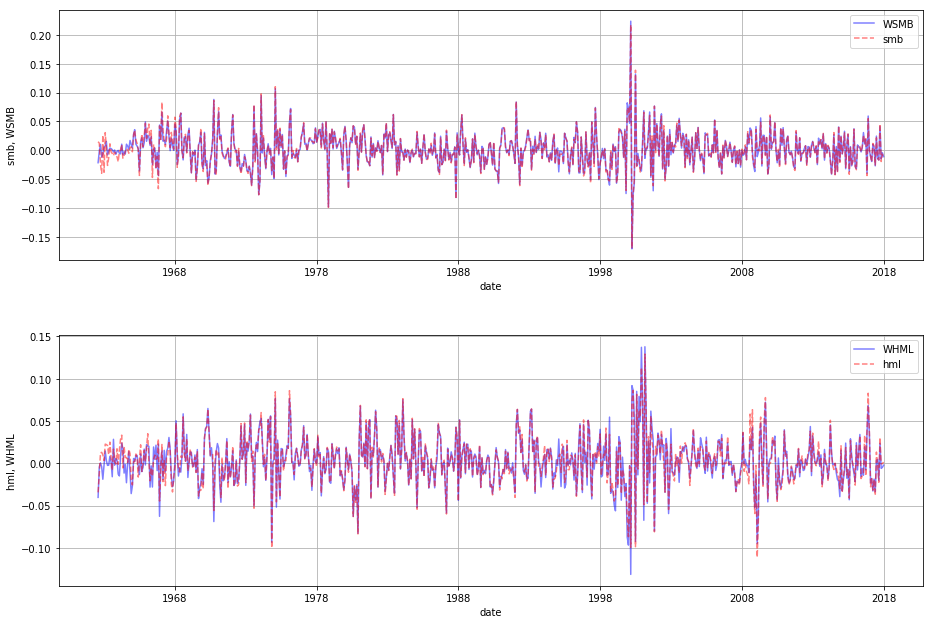

In [153]:
plt.figure()
plt.subplot(211)
plt.plot(_ffcomp.date, _ffcomp.WSMB, 'b', alpha=0.5)
plt.plot(_ffcomp.date, _ffcomp.smb, 'r--', alpha=0.5)
plt.xlabel('date')
plt.ylabel('smb, WSMB')
plt.legend(['WSMB', 'smb'])
plt.grid(True)

plt.subplot(212)
plt.plot(_ffcomp.date, _ffcomp.WHML, 'b', alpha=0.5)
plt.plot(_ffcomp.date, _ffcomp.hml, 'r--', alpha=0.5)
plt.xlabel('date')
plt.ylabel('hml, WHML')
plt.legend(['WHML', 'hml'])
plt.grid(True)

plt.subplots_adjust(top=2, bottom=0, left=0, right=2, hspace=0.3,
                    wspace=0.0)

plt.show()

## References

Barber, Brad M. and Terrance Odean, 2000, Trading Is Hazardous to Your Wealth: The Common Stock Investment Performance of Individual Investors, The Journal of Finance , 55, 773-806.

Cremers, Martijn, Petajisto, Antti and Zitzewitz, Eric, Should Benchmark Indices Have Alpha? Revisiting Performance Evaluation (January, 2010). Available at SSRN: http://ssrn.com/abstract=1108856.

Carhart, Mark M., 1997, On Persistence in Mutual Fund Performance, The Journal of Finance , 52, 57-82.

Davis, James , Eugene Fama and Kenneth R. French, 2000, Characteristics, Covariances, and Average Returns: 1929 to 1997, The Journal of Finance , 55, 389-406.

Fama, Eugene F. and Kenneth R. French, 1993, Common Risk Factors in Stocks and Bonds, Journal of Financial Economics , 33, 3-56.

Womack , Kent L., 1996, Do Brokerage Analysts' Recommendations Have Investment Value?, The Journal of Finance , 51, 137-167.